In [ ]:
!pip install supervision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import torch
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.spatial import KDTree
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from ultralytics import YOLO
import supervision as sv

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Analyzing insideb.jpeg...

image 1/1 /content/insideb.jpeg: 640x480 2 chairs, 1 couch, 3024.3ms
Speed: 3.2ms preprocess, 3024.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)
Detected chair with 0.930 confidence at position 117,1244,470,1816
Detected couch with 0.832 confidence at position 560,1032,662,1348
Detected chair with 0.331 confidence at position 844,1095,931,1248

Detected Objects Summary:
--------------------------------------------------
Type: chair
Confidence: 0.930
Estimated Distance: 6.06 feet
------------------------------
Type: couch
Confidence: 0.832
Estimated Distance: 1.45 feet
------------------------------
Type: chair
Confidence: 0.331
Estimated Distance: 0.31 feet
------------------------------

Safety Alerts:
- MEDIUM: Safety concern: chair and couch are too close (4.65 feet)
- HIGH: Safety concern: couch and chair are too close (2.77 feet)

Spatial Relationships:
- chair is left of couch
- couch is left of chair
- chair is right of couch


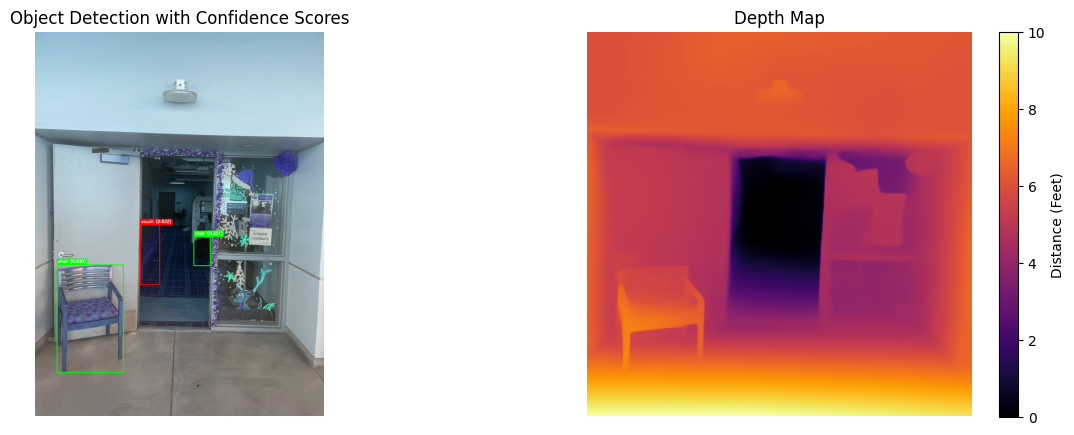

In [ ]:
class SceneAnalyzer:
    def __init__(self, depth_model_name="Intel/dpt-large", yolo_model_name="yolov8x.pt"):
        """Initialize models and parameters"""
        self.depth_feature_extractor = DPTFeatureExtractor.from_pretrained(depth_model_name)
        self.depth_model = DPTForDepthEstimation.from_pretrained(depth_model_name)
        self.yolo_model = YOLO(yolo_model_name)
        self.scaling_factor = 10
        self.safety_threshold = 6  # minimum safe distance in feet
        self.historical_data = []

    def detect_objects(self, image_path):
        """
        Perform object detection on the image

        Args:
            image_path (str): Path to the image file

        Returns:
            list: List of YOLO detection results
        """
        results = self.yolo_model(image_path)
        return results

    def estimate_depth(self, image):
        """Estimate depth map from image and return both depth map and scale factors"""
        depth_inputs = self.depth_feature_extractor(images=image, return_tensors="pt")
        with torch.no_grad():
            depth_outputs = self.depth_model(**depth_inputs)
            predicted_depth = depth_outputs.predicted_depth.squeeze().cpu().numpy()

        depth_min, depth_max = predicted_depth.min(), predicted_depth.max()
        normalized_depth = (predicted_depth - depth_min) / (depth_max - depth_min)

        # Calculate scale factors between original image and depth map
        original_height, original_width = np.array(image).shape[:2]
        depth_height, depth_width = normalized_depth.shape
        height_scale = depth_height / original_height
        width_scale = depth_width / original_width

        return normalized_depth * self.scaling_factor, (height_scale, width_scale)

    def draw_annotations(self, image, detections, names, confidences):
        """Draw bounding boxes and labels using cv2 with enhanced visibility"""
        annotated_image = image.copy()

        for i, (box, class_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
            x1, y1, x2, y2 = map(int, box)

            # Use different colors for different classes
            color = (0, 255, 0) if names[class_id] == 'chair' else (0, 0, 255)

            # Draw rectangle with thicker lines
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 3)

            # Create more detailed label
            label = f"{names[class_id]} ({conf:.3f})"

            # Make text background and font larger
            font_scale = 0.7
            thickness = 2
            (label_width, label_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
            )

            # Draw label background
            cv2.rectangle(
                annotated_image,
                (x1, y1 - label_height - baseline - 10),
                (x1 + label_width + 10, y1),
                color,
                -1,
            )

            # Draw label text in white for better contrast
            cv2.putText(
                annotated_image,
                label,
                (x1 + 5, y1 - baseline - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                thickness,
            )

            # Print detection details to console
            print(f"Detected {names[class_id]} with {conf:.3f} confidence at position {x1},{y1},{x2},{y2}")

        return annotated_image

    def analyze_scene(self, image_path):
        """Main method to analyze the scene with enhanced debugging"""
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]

        print("\nDetection Results:")
        print("-" * 50)

        # Print all detections with confidence scores
        for i, (box, cls, conf) in enumerate(zip(yolo_results.boxes.xyxy,
                                               yolo_results.boxes.cls,
                                               yolo_results.boxes.conf)):
            print(f"Object {i+1}:")
            print(f"  Class: {yolo_results.names[int(cls)]}")
            print(f"  Confidence: {conf:.3f}")
            print(f"  Bounding Box: {box.tolist()}")
            print()

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

    def calculate_spatial_relationships(self, detections, names):
        """Calculate spatial relationships between objects"""
        relationships = []
        if len(detections.xyxy) > 1:
            # Calculate center points of all bounding boxes
            centers = np.array([
                [(box[0] + box[2])/2, (box[1] + box[3])/2]
                for box in detections.xyxy
            ])

            tree = KDTree(centers)
            for i, pos in enumerate(centers):
                distances, indices = tree.query(pos.reshape(1, -1), k=2)
                if len(indices[0]) > 1:
                    nearest_neighbor = indices[0][1]
                    # Use object names instead of class IDs
                    relationships.append({
                        'object1': names[detections.class_id[i]],
                        'object2': names[detections.class_id[nearest_neighbor]],
                        'distance': float(distances[0][1]),
                        'relative_position': 'left' if centers[i][0] < centers[nearest_neighbor][0] else 'right'
                    })
        return relationships

    def generate_safety_alerts(self, detections, names):
        """Generate safety alerts based on object proximity"""
        alerts = []
        processed_pairs = set()  # To avoid duplicate alerts

        for i in range(len(detections.xyxy)):
            for j in range(i + 1, len(detections.xyxy)):
                # Create a unique pair identifier
                pair_id = tuple(sorted([i, j]))
                if pair_id in processed_pairs:
                    continue

                processed_pairs.add(pair_id)

                box1 = detections.xyxy[i]
                box2 = detections.xyxy[j]
                center1 = [(box1[0] + box1[2])/2, (box1[1] + box1[3])/2]
                center2 = [(box2[0] + box2[2])/2, (box2[1] + box2[3])/2]
                dist = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

                if dist < self.safety_threshold * 100:  # Convert feet to pixels
                    alerts.append({
                        'severity': 'HIGH' if dist < self.safety_threshold * 50 else 'MEDIUM',
                        'message': f"Safety concern: {names[detections.class_id[i]]} and {names[detections.class_id[j]]} are too close",
                        'distance': dist / 100  # Convert to feet
                    })
        return alerts

    def analyze_scene(self, image_path):
        """Main method to analyze the scene"""
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]  # Get first result

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

        # Draw annotations using our custom method
        annotated_image = self.draw_annotations(
            image_np,
            detections,
            yolo_results.names,
            detections.confidence
        )

        # Process detection results
        object_data = []
        height_scale, width_scale = scale_factors

        for i, (xyxy, confidence, class_id) in enumerate(zip(detections.xyxy, detections.confidence, detections.class_id)):
            x1, y1, x2, y2 = map(int, xyxy)

            # Scale coordinates for depth map
            scaled_x1 = int(x1 * width_scale)
            scaled_y1 = int(y1 * height_scale)
            scaled_x2 = int(x2 * width_scale)
            scaled_y2 = int(y2 * height_scale)

            # Ensure coordinates are within bounds
            scaled_x1 = min(max(0, scaled_x1), estimated_distance.shape[1] - 1)
            scaled_y1 = min(max(0, scaled_y1), estimated_distance.shape[0] - 1)
            scaled_x2 = min(max(0, scaled_x2), estimated_distance.shape[1] - 1)
            scaled_y2 = min(max(0, scaled_y2), estimated_distance.shape[0] - 1)

            # Calculate object distance using scaled coordinates
            object_depth = estimated_distance[scaled_y1:scaled_y2, scaled_x1:scaled_x2]
            object_distance = float(np.mean(object_depth)) if object_depth.size > 0 else None

            # Store object data
            object_data.append({
                'type': yolo_results.names[class_id],
                'confidence': float(confidence),
                'distance': object_distance,
                'position': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}
            })

        # Calculate additional analysis using object names instead of class IDs
        spatial_relationships = self.calculate_spatial_relationships(detections, yolo_results.names)
        safety_alerts = self.generate_safety_alerts(detections, yolo_results.names)

        # Store historical data (without JSON serialization)
        analysis_data = {
            'timestamp': datetime.now().isoformat(),
            'objects': object_data,
            'relationships': spatial_relationships,
            'alerts': safety_alerts
        }
        self.historical_data.append(analysis_data)

        # Create basic visualizations
        fig = plt.figure(figsize=(15, 5))

        # Original image with annotations
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Object Detection with Confidence Scores")
        plt.axis("off")

        # Depth map
        plt.subplot(1, 2, 2)
        depth_plot = plt.imshow(estimated_distance, cmap="inferno")
        plt.colorbar(depth_plot, label="Distance (Feet)")
        plt.title("Depth Map")
        plt.axis("off")

        return {
            'annotated_image': annotated_image,
            'depth_map': estimated_distance,
            'object_data': object_data,
            'spatial_relationships': spatial_relationships,
            'safety_alerts': safety_alerts,
            'figure': fig
        }

# Example usage
if __name__ == "__main__":
    analyzer = SceneAnalyzer()

    image_paths = [
        "insideb.jpeg"
    ]

    for image_path in image_paths:
        print(f"\nAnalyzing {image_path}...")
        results = analyzer.analyze_scene(image_path)

        # Enhanced printing of object details
        print("\nDetected Objects Summary:")
        print("-" * 50)
        for obj in results['object_data']:
            print(f"Type: {obj['type']}")
            print(f"Confidence: {obj['confidence']:.3f}")
            print(f"Estimated Distance: {obj['distance']:.2f} feet")
            print("-" * 30)

        if results['safety_alerts']:
            print("\nSafety Alerts:")
            for alert in results['safety_alerts']:
                print(f"- {alert['severity']}: {alert['message']} ({alert['distance']:.2f} feet)")

        if results['spatial_relationships']:
            print("\nSpatial Relationships:")
            for rel in results['spatial_relationships']:
                print(f"- {rel['object1']} is {rel['relative_position']} of {rel['object2']}")

        plt.figure(results['figure'].number)
        plt.show()

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 131M/131M [00:00<00:00, 214MB/s]



Analyzing insidec.jpeg...

image 1/1 /content/insidec.jpeg: 448x640 19 chairs, 2 dining tables, 1 tv, 5 laptops, 1 book, 2797.6ms
Speed: 2.6ms preprocess, 2797.6ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
Detected chair with 0.892 confidence at position 440,456,516,563
Detected laptop with 0.890 confidence at position 117,381,304,527
Detected laptop with 0.868 confidence at position 0,370,69,444
Detected chair with 0.855 confidence at position 636,313,739,501
Detected chair with 0.830 confidence at position 185,368,295,412
Detected chair with 0.827 confidence at position 404,279,468,391
Detected chair with 0.818 confidence at position 723,315,834,501
Detected chair with 0.810 confidence at position 555,305,651,484
Detected laptop with 0.793 confidence at position 196,284,265,318
Detected chair with 0.758 confidence at position 42,319,150,397
Detected chair with 0.743 confidence at position 159,315,251,390
Detected laptop with 0.733 confidence at position 79,277

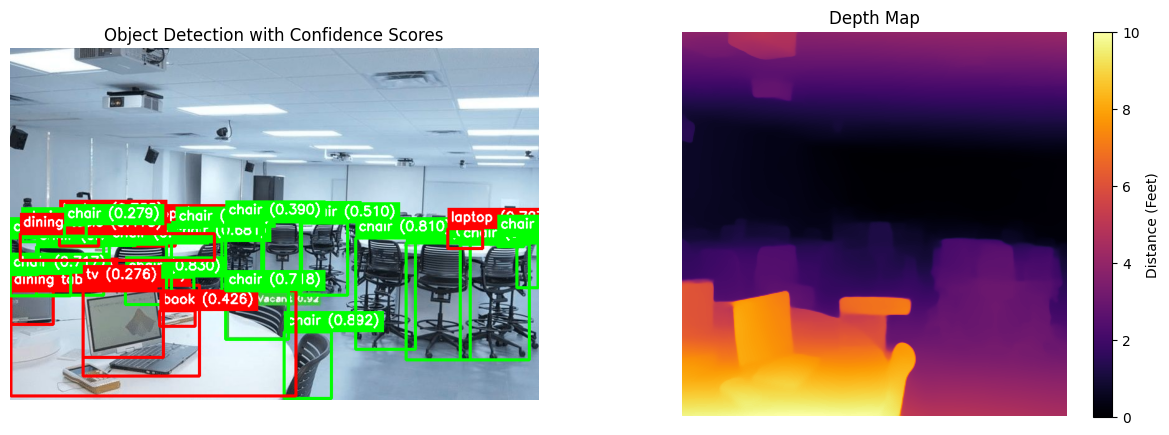

In [ ]:
class SceneAnalyzer:
    def __init__(self, depth_model_name="Intel/dpt-large", yolo_model_name="yolov8x.pt"):
        """Initialize models and parameters"""
        self.depth_feature_extractor = DPTFeatureExtractor.from_pretrained(depth_model_name)
        self.depth_model = DPTForDepthEstimation.from_pretrained(depth_model_name)
        self.yolo_model = YOLO(yolo_model_name, classes= [576, 136, 153, 164, 381, 585, 514])
        self.scaling_factor = 10
        self.safety_threshold = 6  # minimum safe distance in feet
        self.historical_data = []

    def detect_objects(self, image_path):
        """
        Perform object detection on the image

        Args:
            image_path (str): Path to the image file

        Returns:
            list: List of YOLO detection results
        """
        results = self.yolo_model(image_path)
        return results

    def estimate_depth(self, image):
        """Estimate depth map from image and return both depth map and scale factors"""
        depth_inputs = self.depth_feature_extractor(images=image, return_tensors="pt")
        with torch.no_grad():
            depth_outputs = self.depth_model(**depth_inputs)
            predicted_depth = depth_outputs.predicted_depth.squeeze().cpu().numpy()

        depth_min, depth_max = predicted_depth.min(), predicted_depth.max()
        normalized_depth = (predicted_depth - depth_min) / (depth_max - depth_min)

        # Calculate scale factors between original image and depth map
        original_height, original_width = np.array(image).shape[:2]
        depth_height, depth_width = normalized_depth.shape
        height_scale = depth_height / original_height
        width_scale = depth_width / original_width

        return normalized_depth * self.scaling_factor, (height_scale, width_scale)

    def draw_annotations(self, image, detections, names, confidences):
        """Draw bounding boxes and labels using cv2 with enhanced visibility"""
        annotated_image = image.copy()

        for i, (box, class_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
            x1, y1, x2, y2 = map(int, box)

            # Use different colors for different classes
            color = (0, 255, 0) if names[class_id] == 'chair' else (0, 0, 255)

            # Draw rectangle with thicker lines
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 3)

            # Create more detailed label
            label = f"{names[class_id]} ({conf:.3f})"

            # Make text background and font larger
            font_scale = 0.7
            thickness = 2
            (label_width, label_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
            )

            # Draw label background
            cv2.rectangle(
                annotated_image,
                (x1, y1 - label_height - baseline - 10),
                (x1 + label_width + 10, y1),
                color,
                -1,
            )

            # Draw label text in white for better contrast
            cv2.putText(
                annotated_image,
                label,
                (x1 + 5, y1 - baseline - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                thickness,
            )

            # Print detection details to console
            print(f"Detected {names[class_id]} with {conf:.3f} confidence at position {x1},{y1},{x2},{y2}")

        return annotated_image

    def analyze_scene(self, image_path):
        """Main method to analyze the scene with enhanced debugging"""
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]

        print("\nDetection Results:")
        print("-" * 50)

        # Print all detections with confidence scores
        for i, (box, cls, conf) in enumerate(zip(yolo_results.boxes.xyxy,
                                               yolo_results.boxes.cls,
                                               yolo_results.boxes.conf)):
            print(f"Object {i+1}:")
            print(f"  Class: {yolo_results.names[int(cls)]}")
            print(f"  Confidence: {conf:.3f}")
            print(f"  Bounding Box: {box.tolist()}")
            print()

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

    def calculate_spatial_relationships(self, detections, names):
        """Calculate spatial relationships between objects"""
        relationships = []
        if len(detections.xyxy) > 1:
            # Calculate center points of all bounding boxes
            centers = np.array([
                [(box[0] + box[2])/2, (box[1] + box[3])/2]
                for box in detections.xyxy
            ])

            tree = KDTree(centers)
            for i, pos in enumerate(centers):
                distances, indices = tree.query(pos.reshape(1, -1), k=2)
                if len(indices[0]) > 1:
                    nearest_neighbor = indices[0][1]
                    # Use object names instead of class IDs
                    relationships.append({
                        'object1': names[detections.class_id[i]],
                        'object2': names[detections.class_id[nearest_neighbor]],
                        'distance': float(distances[0][1]),
                        'relative_position': 'left' if centers[i][0] < centers[nearest_neighbor][0] else 'right'
                    })
        return relationships

    def generate_safety_alerts(self, detections, names):
        """Generate safety alerts based on object proximity"""
        alerts = []
        processed_pairs = set()  # To avoid duplicate alerts

        for i in range(len(detections.xyxy)):
            for j in range(i + 1, len(detections.xyxy)):
                # Create a unique pair identifier
                pair_id = tuple(sorted([i, j]))
                if pair_id in processed_pairs:
                    continue

                processed_pairs.add(pair_id)

                box1 = detections.xyxy[i]
                box2 = detections.xyxy[j]
                center1 = [(box1[0] + box1[2])/2, (box1[1] + box1[3])/2]
                center2 = [(box2[0] + box2[2])/2, (box2[1] + box2[3])/2]
                dist = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

                if dist < self.safety_threshold * 100:  # Convert feet to pixels
                    alerts.append({
                        'severity': 'HIGH' if dist < self.safety_threshold * 50 else 'MEDIUM',
                        'message': f"Safety concern: {names[detections.class_id[i]]} and {names[detections.class_id[j]]} are too close",
                        'distance': dist / 100  # Convert to feet
                    })
        return alerts

    def analyze_scene(self, image_path):
        """Main method to analyze the scene"""
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]  # Get first result

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

        # Draw annotations using our custom method
        annotated_image = self.draw_annotations(
            image_np,
            detections,
            yolo_results.names,
            detections.confidence
        )

        # Process detection results
        object_data = []
        height_scale, width_scale = scale_factors

        for i, (xyxy, confidence, class_id) in enumerate(zip(detections.xyxy, detections.confidence, detections.class_id)):
            x1, y1, x2, y2 = map(int, xyxy)

            # Scale coordinates for depth map
            scaled_x1 = int(x1 * width_scale)
            scaled_y1 = int(y1 * height_scale)
            scaled_x2 = int(x2 * width_scale)
            scaled_y2 = int(y2 * height_scale)

            # Ensure coordinates are within bounds
            scaled_x1 = min(max(0, scaled_x1), estimated_distance.shape[1] - 1)
            scaled_y1 = min(max(0, scaled_y1), estimated_distance.shape[0] - 1)
            scaled_x2 = min(max(0, scaled_x2), estimated_distance.shape[1] - 1)
            scaled_y2 = min(max(0, scaled_y2), estimated_distance.shape[0] - 1)

            # Calculate object distance using scaled coordinates
            object_depth = estimated_distance[scaled_y1:scaled_y2, scaled_x1:scaled_x2]
            object_distance = float(np.mean(object_depth)) if object_depth.size > 0 else None

            # Store object data
            object_data.append({
                'type': yolo_results.names[class_id],
                'confidence': float(confidence),
                'distance': object_distance,
                'position': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}
            })

        # Calculate additional analysis using object names instead of class IDs
        spatial_relationships = self.calculate_spatial_relationships(detections, yolo_results.names)
        safety_alerts = self.generate_safety_alerts(detections, yolo_results.names)

        # Store historical data (without JSON serialization)
        analysis_data = {
            'timestamp': datetime.now().isoformat(),
            'objects': object_data,
            'relationships': spatial_relationships,
            'alerts': safety_alerts
        }
        self.historical_data.append(analysis_data)

        # Create basic visualizations
        fig = plt.figure(figsize=(15, 5))

        # Original image with annotations
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Object Detection with Confidence Scores")
        plt.axis("off")

        # Depth map
        plt.subplot(1, 2, 2)
        depth_plot = plt.imshow(estimated_distance, cmap="inferno")
        plt.colorbar(depth_plot, label="Distance (Feet)")
        plt.title("Depth Map")
        plt.axis("off")

        return {
            'annotated_image': annotated_image,
            'depth_map': estimated_distance,
            'object_data': object_data,
            'spatial_relationships': spatial_relationships,
            'safety_alerts': safety_alerts,
            'figure': fig
        }

# Example usage
if __name__ == "__main__":
    analyzer = SceneAnalyzer()

    image_paths = [
        "insidec.jpeg"
    ]

    for image_path in image_paths:
        print(f"\nAnalyzing {image_path}...")
        results = analyzer.analyze_scene(image_path)

        # Enhanced printing of object details
        print("\nDetected Objects Summary:")
        print("-" * 50)
        for obj in results['object_data']:
            print(f"Type: {obj['type']}")
            print(f"Confidence: {obj['confidence']:.3f}")
            print(f"Estimated Distance: {obj['distance']:.2f} feet")
            print("-" * 30)

        if results['safety_alerts']:
            print("\nSafety Alerts:")
            for alert in results['safety_alerts']:
                print(f"- {alert['severity']}: {alert['message']} ({alert['distance']:.2f} feet)")

        if results['spatial_relationships']:
            print("\nSpatial Relationships:")
            for rel in results['spatial_relationships']:
                print(f"- {rel['object1']} is {rel['relative_position']} of {rel['object2']}")

        plt.figure(results['figure'].number)
        plt.show()

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Analyzing insidez.jpeg...

image 1/1 /content/insidez.jpeg: 640x480 1 Chair, 1 Zebra, 2921.4ms
Speed: 3.2ms preprocess, 2921.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)
Detected Zebra with 0.898 confidence at position 568,1796,847,2047
Detected Chair with 0.842 confidence at position 97,1232,476,1803

Detected Objects Summary:
--------------------------------------------------
Type: Zebra
Confidence: 0.898
Estimated Distance: 8.07 feet
------------------------------
Type: Chair
Confidence: 0.842
Estimated Distance: 4.65 feet
------------------------------

Safety Alerts:
- MEDIUM: Safety concern: Zebra and Chair are too close (5.83 feet)

Spatial Relationships:
- Zebra is right of Chair
- Chair is left of Zebra


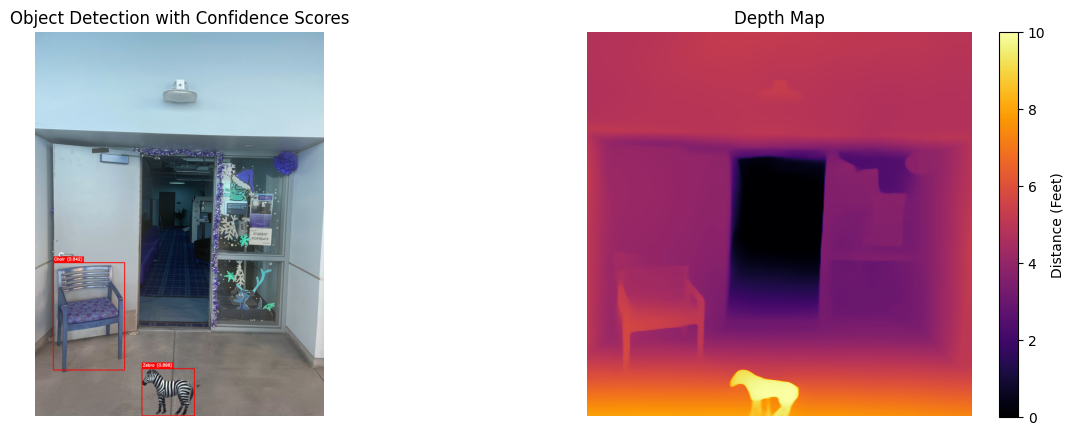

In [ ]:
class SceneAnalyzer:
    def __init__(self, depth_model_name="Intel/dpt-large", yolo_model_name="yolov8x-oiv7.pt"):
        """Initialize models and parameters"""
        self.depth_feature_extractor = DPTFeatureExtractor.from_pretrained(depth_model_name)
        self.depth_model = DPTForDepthEstimation.from_pretrained(depth_model_name)
        self.yolo_model = YOLO(yolo_model_name)
        self.scaling_factor = 10
        self.safety_threshold = 6  # minimum safe distance in feet
        self.historical_data = []

    def detect_objects(self, image_path):
        """
        Perform object detection on the image

        Args:
            image_path (str): Path to the image file

        Returns:
            list: List of YOLO detection results
        """
        results = self.yolo_model(image_path, classes = [576, 136, 153, 164, 381, 585, 514, 104, 599])
        return results

    def estimate_depth(self, image):
        """Estimate depth map from image and return both depth map and scale factors"""
        depth_inputs = self.depth_feature_extractor(images=image, return_tensors="pt")
        with torch.no_grad():
            depth_outputs = self.depth_model(**depth_inputs)
            predicted_depth = depth_outputs.predicted_depth.squeeze().cpu().numpy()

        depth_min, depth_max = predicted_depth.min(), predicted_depth.max()
        normalized_depth = (predicted_depth - depth_min) / (depth_max - depth_min)

        # Calculate scale factors between original image and depth map
        original_height, original_width = np.array(image).shape[:2]
        depth_height, depth_width = normalized_depth.shape
        height_scale = depth_height / original_height
        width_scale = depth_width / original_width

        return normalized_depth * self.scaling_factor, (height_scale, width_scale)

    def draw_annotations(self, image, detections, names, confidences):
        """Draw bounding boxes and labels using cv2 with enhanced visibility"""
        annotated_image = image.copy()

        for i, (box, class_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
            x1, y1, x2, y2 = map(int, box)

            # Use different colors for different classes
            color = (0, 255, 0) if names[class_id] == 'chair' else (0, 0, 255)

            # Draw rectangle with thicker lines
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 3)

            # Create more detailed label
            label = f"{names[class_id]} ({conf:.3f})"

            # Make text background and font larger
            font_scale = 0.7
            thickness = 2
            (label_width, label_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
            )

            # Draw label background
            cv2.rectangle(
                annotated_image,
                (x1, y1 - label_height - baseline - 10),
                (x1 + label_width + 10, y1),
                color,
                -1,
            )

            # Draw label text in white for better contrast
            cv2.putText(
                annotated_image,
                label,
                (x1 + 5, y1 - baseline - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                thickness,
            )

            # Print detection details to console
            print(f"Detected {names[class_id]} with {conf:.3f} confidence at position {x1},{y1},{x2},{y2}")

        return annotated_image

    def analyze_scene(self, image_path):
        """Main method to analyze the scene with enhanced debugging"""
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]

        print("\nDetection Results:")
        print("-" * 50)

        # Print all detections with confidence scores
        for i, (box, cls, conf) in enumerate(zip(yolo_results.boxes.xyxy,
                                               yolo_results.boxes.cls,
                                               yolo_results.boxes.conf)):
            print(f"Object {i+1}:")
            print(f"  Class: {yolo_results.names[int(cls)]}")
            print(f"  Confidence: {conf:.3f}")
            print(f"  Bounding Box: {box.tolist()}")
            print()

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

    def calculate_spatial_relationships(self, detections, names):
        """Calculate spatial relationships between objects"""
        relationships = []
        if len(detections.xyxy) > 1:
            # Calculate center points of all bounding boxes
            centers = np.array([
                [(box[0] + box[2])/2, (box[1] + box[3])/2]
                for box in detections.xyxy
            ])

            tree = KDTree(centers)
            for i, pos in enumerate(centers):
                distances, indices = tree.query(pos.reshape(1, -1), k=2)
                if len(indices[0]) > 1:
                    nearest_neighbor = indices[0][1]
                    # Use object names instead of class IDs
                    relationships.append({
                        'object1': names[detections.class_id[i]],
                        'object2': names[detections.class_id[nearest_neighbor]],
                        'distance': float(distances[0][1]),
                        'relative_position': 'left' if centers[i][0] < centers[nearest_neighbor][0] else 'right'
                    })
        return relationships

    def generate_safety_alerts(self, detections, names):
        """Generate safety alerts based on object proximity"""
        alerts = []
        processed_pairs = set()  # To avoid duplicate alerts

        for i in range(len(detections.xyxy)):
            for j in range(i + 1, len(detections.xyxy)):
                # Create a unique pair identifier
                pair_id = tuple(sorted([i, j]))
                if pair_id in processed_pairs:
                    continue

                processed_pairs.add(pair_id)

                box1 = detections.xyxy[i]
                box2 = detections.xyxy[j]
                center1 = [(box1[0] + box1[2])/2, (box1[1] + box1[3])/2]
                center2 = [(box2[0] + box2[2])/2, (box2[1] + box2[3])/2]
                dist = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

                if dist < self.safety_threshold * 100:  # Convert feet to pixels
                    alerts.append({
                        'severity': 'HIGH' if dist < self.safety_threshold * 50 else 'MEDIUM',
                        'message': f"Safety concern: {names[detections.class_id[i]]} and {names[detections.class_id[j]]} are too close",
                        'distance': dist / 100  # Convert to feet
                    })
        return alerts

    def analyze_scene(self, image_path):
        """Main method to analyze the scene"""
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]  # Get first result

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

        # Draw annotations using our custom method
        annotated_image = self.draw_annotations(
            image_np,
            detections,
            yolo_results.names,
            detections.confidence
        )

        # Process detection results
        object_data = []
        height_scale, width_scale = scale_factors

        for i, (xyxy, confidence, class_id) in enumerate(zip(detections.xyxy, detections.confidence, detections.class_id)):
            x1, y1, x2, y2 = map(int, xyxy)

            # Scale coordinates for depth map
            scaled_x1 = int(x1 * width_scale)
            scaled_y1 = int(y1 * height_scale)
            scaled_x2 = int(x2 * width_scale)
            scaled_y2 = int(y2 * height_scale)

            # Ensure coordinates are within bounds
            scaled_x1 = min(max(0, scaled_x1), estimated_distance.shape[1] - 1)
            scaled_y1 = min(max(0, scaled_y1), estimated_distance.shape[0] - 1)
            scaled_x2 = min(max(0, scaled_x2), estimated_distance.shape[1] - 1)
            scaled_y2 = min(max(0, scaled_y2), estimated_distance.shape[0] - 1)

            # Calculate object distance using scaled coordinates
            object_depth = estimated_distance[scaled_y1:scaled_y2, scaled_x1:scaled_x2]
            object_distance = float(np.mean(object_depth)) if object_depth.size > 0 else None

            # Store object data
            object_data.append({
                'type': yolo_results.names[class_id],
                'confidence': float(confidence),
                'distance': object_distance,
                'position': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}
            })

        # Calculate additional analysis using object names instead of class IDs
        spatial_relationships = self.calculate_spatial_relationships(detections, yolo_results.names)
        safety_alerts = self.generate_safety_alerts(detections, yolo_results.names)

        # Store historical data (without JSON serialization)
        analysis_data = {
            'timestamp': datetime.now().isoformat(),
            'objects': object_data,
            'relationships': spatial_relationships,
            'alerts': safety_alerts
        }
        self.historical_data.append(analysis_data)

        # Create basic visualizations
        fig = plt.figure(figsize=(15, 5))

        # Original image with annotations
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Object Detection with Confidence Scores")
        plt.axis("off")

        # Depth map
        plt.subplot(1, 2, 2)
        depth_plot = plt.imshow(estimated_distance, cmap="inferno")
        plt.colorbar(depth_plot, label="Distance (Feet)")
        plt.title("Depth Map")
        plt.axis("off")

        return {
            'annotated_image': annotated_image,
            'depth_map': estimated_distance,
            'object_data': object_data,
            'spatial_relationships': spatial_relationships,
            'safety_alerts': safety_alerts,
            'figure': fig
        }

# Example usage
if __name__ == "__main__":
    analyzer = SceneAnalyzer()

    image_paths = [
        "insidez.jpeg"
    ]

    for image_path in image_paths:
        print(f"\nAnalyzing {image_path}...")
        results = analyzer.analyze_scene(image_path)

        # Enhanced printing of object details
        print("\nDetected Objects Summary:")
        print("-" * 50)
        for obj in results['object_data']:
            print(f"Type: {obj['type']}")
            print(f"Confidence: {obj['confidence']:.3f}")
            print(f"Estimated Distance: {obj['distance']:.2f} feet")
            print("-" * 30)

        if results['safety_alerts']:
            print("\nSafety Alerts:")
            for alert in results['safety_alerts']:
                print(f"- {alert['severity']}: {alert['message']} ({alert['distance']:.2f} feet)")

        if results['spatial_relationships']:
            print("\nSpatial Relationships:")
            for rel in results['spatial_relationships']:
                print(f"- {rel['object1']} is {rel['relative_position']} of {rel['object2']}")

        plt.figure(results['figure'].number)
        plt.show()

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 131M/131M [00:01<00:00, 110MB/s]



Analyzing dustbin.png...

image 1/1 /content/dustbin.png: 640x512 (no detections), 4966.4ms
Speed: 21.8ms preprocess, 4966.4ms inference, 16.9ms postprocess per image at shape (1, 3, 640, 512)

Detected Objects Summary:
--------------------------------------------------


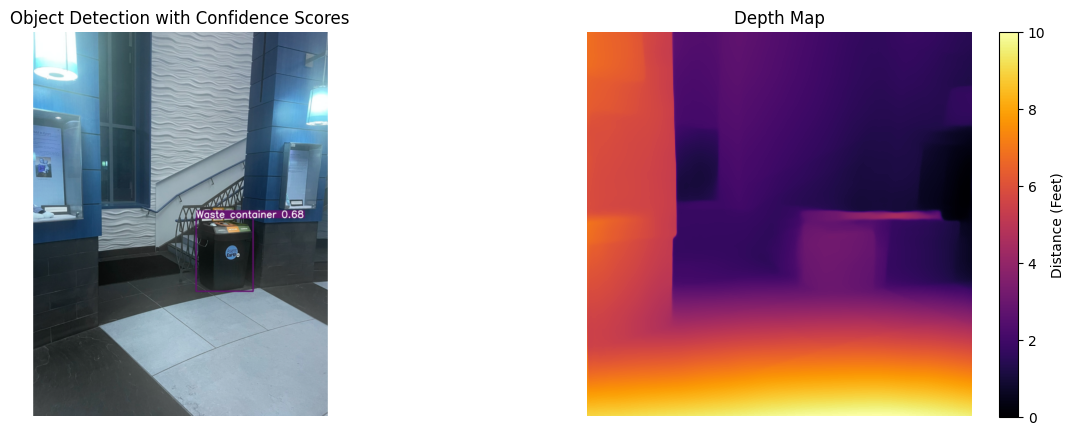

In [ ]:
class SceneAnalyzer:
    def __init__(self, depth_model_name="Intel/dpt-large", yolo_model_name="yolov8x.pt"):
        """Initialize models and parameters"""
        self.depth_feature_extractor = DPTFeatureExtractor.from_pretrained(depth_model_name)
        self.depth_model = DPTForDepthEstimation.from_pretrained(depth_model_name)
        self.yolo_model = YOLO(yolo_model_name)
        self.scaling_factor = 10
        self.safety_threshold = 6  # minimum safe distance in feet
        self.historical_data = []

    def detect_objects(self, image_path):
        """
        Perform object detection on the image

        Args:
            image_path (str): Path to the image file

        Returns:
            list: List of YOLO detection results
        """
        results = self.yolo_model(image_path)
        return results

    def estimate_depth(self, image):
        """Estimate depth map from image and return both depth map and scale factors"""
        depth_inputs = self.depth_feature_extractor(images=image, return_tensors="pt")
        with torch.no_grad():
            depth_outputs = self.depth_model(**depth_inputs)
            predicted_depth = depth_outputs.predicted_depth.squeeze().cpu().numpy()

        depth_min, depth_max = predicted_depth.min(), predicted_depth.max()
        normalized_depth = (predicted_depth - depth_min) / (depth_max - depth_min)

        # Calculate scale factors between original image and depth map
        original_height, original_width = np.array(image).shape[:2]
        depth_height, depth_width = normalized_depth.shape
        height_scale = depth_height / original_height
        width_scale = depth_width / original_width

        return normalized_depth * self.scaling_factor, (height_scale, width_scale)

    def draw_annotations(self, image, detections, names, confidences):
        """Draw bounding boxes and labels using cv2 with enhanced visibility"""
        annotated_image = image.copy()

        for i, (box, class_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
            x1, y1, x2, y2 = map(int, box)

            # Use different colors for different classes
            color = (0, 255, 0) if names[class_id] == 'chair' else (0, 0, 255)

            # Draw rectangle with thicker lines
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 3)

            # Create more detailed label
            label = f"{names[class_id]} ({conf:.3f})"

            # Make text background and font larger
            font_scale = 0.7
            thickness = 2
            (label_width, label_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
            )

            # Draw label background
            cv2.rectangle(
                annotated_image,
                (x1, y1 - label_height - baseline - 10),
                (x1 + label_width + 10, y1),
                color,
                -1,
            )

            # Draw label text in white for better contrast
            cv2.putText(
                annotated_image,
                label,
                (x1 + 5, y1 - baseline - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                thickness,
            )

            # Print detection details to console
            print(f"Detected {names[class_id]} with {conf:.3f} confidence at position {x1},{y1},{x2},{y2}")

        return annotated_image

    def analyze_scene(self, image_path):
        """Main method to analyze the scene with enhanced debugging"""
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]

        print("\nDetection Results:")
        print("-" * 50)

        # Print all detections with confidence scores
        for i, (box, cls, conf) in enumerate(zip(yolo_results.boxes.xyxy,
                                               yolo_results.boxes.cls,
                                               yolo_results.boxes.conf)):
            print(f"Object {i+1}:")
            print(f"  Class: {yolo_results.names[int(cls)]}")
            print(f"  Confidence: {conf:.3f}")
            print(f"  Bounding Box: {box.tolist()}")
            print()

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

    def calculate_spatial_relationships(self, detections, names):
        """Calculate spatial relationships between objects"""
        relationships = []
        if len(detections.xyxy) > 1:
            # Calculate center points of all bounding boxes
            centers = np.array([
                [(box[0] + box[2])/2, (box[1] + box[3])/2]
                for box in detections.xyxy
            ])

            tree = KDTree(centers)
            for i, pos in enumerate(centers):
                distances, indices = tree.query(pos.reshape(1, -1), k=2)
                if len(indices[0]) > 1:
                    nearest_neighbor = indices[0][1]
                    # Use object names instead of class IDs
                    relationships.append({
                        'object1': names[detections.class_id[i]],
                        'object2': names[detections.class_id[nearest_neighbor]],
                        'distance': float(distances[0][1]),
                        'relative_position': 'left' if centers[i][0] < centers[nearest_neighbor][0] else 'right'
                    })
        return relationships

    def generate_safety_alerts(self, detections, names):
        """Generate safety alerts based on object proximity"""
        alerts = []
        processed_pairs = set()  # To avoid duplicate alerts

        for i in range(len(detections.xyxy)):
            for j in range(i + 1, len(detections.xyxy)):
                # Create a unique pair identifier
                pair_id = tuple(sorted([i, j]))
                if pair_id in processed_pairs:
                    continue

                processed_pairs.add(pair_id)

                box1 = detections.xyxy[i]
                box2 = detections.xyxy[j]
                center1 = [(box1[0] + box1[2])/2, (box1[1] + box1[3])/2]
                center2 = [(box2[0] + box2[2])/2, (box2[1] + box2[3])/2]
                dist = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

                if dist < self.safety_threshold * 100:  # Convert feet to pixels
                    alerts.append({
                        'severity': 'HIGH' if dist < self.safety_threshold * 50 else 'MEDIUM',
                        'message': f"Safety concern: {names[detections.class_id[i]]} and {names[detections.class_id[j]]} are too close",
                        'distance': dist / 100  # Convert to feet
                    })
        return alerts

    def analyze_scene(self, image_path):
        """Main method to analyze the scene"""
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]  # Get first result

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

        # Draw annotations using our custom method
        annotated_image = self.draw_annotations(
            image_np,
            detections,
            yolo_results.names,
            detections.confidence
        )

        # Process detection results
        object_data = []
        height_scale, width_scale = scale_factors

        for i, (xyxy, confidence, class_id) in enumerate(zip(detections.xyxy, detections.confidence, detections.class_id)):
            x1, y1, x2, y2 = map(int, xyxy)

            # Scale coordinates for depth map
            scaled_x1 = int(x1 * width_scale)
            scaled_y1 = int(y1 * height_scale)
            scaled_x2 = int(x2 * width_scale)
            scaled_y2 = int(y2 * height_scale)

            # Ensure coordinates are within bounds
            scaled_x1 = min(max(0, scaled_x1), estimated_distance.shape[1] - 1)
            scaled_y1 = min(max(0, scaled_y1), estimated_distance.shape[0] - 1)
            scaled_x2 = min(max(0, scaled_x2), estimated_distance.shape[1] - 1)
            scaled_y2 = min(max(0, scaled_y2), estimated_distance.shape[0] - 1)

            # Calculate object distance using scaled coordinates
            object_depth = estimated_distance[scaled_y1:scaled_y2, scaled_x1:scaled_x2]
            object_distance = float(np.mean(object_depth)) if object_depth.size > 0 else None

            # Store object data
            object_data.append({
                'type': yolo_results.names[class_id],
                'confidence': float(confidence),
                'distance': object_distance,
                'position': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}
            })

        # Calculate additional analysis using object names instead of class IDs
        spatial_relationships = self.calculate_spatial_relationships(detections, yolo_results.names)
        safety_alerts = self.generate_safety_alerts(detections, yolo_results.names)

        # Store historical data (without JSON serialization)
        analysis_data = {
            'timestamp': datetime.now().isoformat(),
            'objects': object_data,
            'relationships': spatial_relationships,
            'alerts': safety_alerts
        }
        self.historical_data.append(analysis_data)

        # Create basic visualizations
        fig = plt.figure(figsize=(15, 5))

        # Original image with annotations
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Object Detection with Confidence Scores")
        plt.axis("off")

        # Depth map
        plt.subplot(1, 2, 2)
        depth_plot = plt.imshow(estimated_distance, cmap="inferno")
        plt.colorbar(depth_plot, label="Distance (Feet)")
        plt.title("Depth Map")
        plt.axis("off")

        return {
            'annotated_image': annotated_image,
            'depth_map': estimated_distance,
            'object_data': object_data,
            'spatial_relationships': spatial_relationships,
            'safety_alerts': safety_alerts,
            'figure': fig
        }

# Example usage
if __name__ == "__main__":
    analyzer = SceneAnalyzer()

    image_paths = [
        "dustbin.png"
    ]

    for image_path in image_paths:
        print(f"\nAnalyzing {image_path}...")
        results = analyzer.analyze_scene(image_path)

        # Enhanced printing of object details
        print("\nDetected Objects Summary:")
        print("-" * 50)
        for obj in results['object_data']:
            print(f"Type: {obj['type']}")
            print(f"Confidence: {obj['confidence']:.3f}")
            print(f"Estimated Distance: {obj['distance']:.2f} feet")
            print("-" * 30)

        if results['safety_alerts']:
            print("\nSafety Alerts:")
            for alert in results['safety_alerts']:
                print(f"- {alert['severity']}: {alert['message']} ({alert['distance']:.2f} feet)")

        if results['spatial_relationships']:
            print("\nSpatial Relationships:")
            for rel in results['spatial_relationships']:
                print(f"- {rel['object1']} is {rel['relative_position']} of {rel['object2']}")

        plt.figure(results['figure'].number)
        plt.show()

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 131M/131M [00:00<00:00, 214MB/s]



Analyzing blackchairs.jpeg...

image 1/1 /content/blackchairs.jpeg: 448x640 19 chairs, 2 dining tables, 1 tv, 5 laptops, 1 book, 3379.9ms
Speed: 3.0ms preprocess, 3379.9ms inference, 21.5ms postprocess per image at shape (1, 3, 448, 640)
Detected chair with 0.892 confidence at position 440,456,516,563
Detected laptop with 0.890 confidence at position 117,381,304,527
Detected laptop with 0.868 confidence at position 0,370,69,444
Detected chair with 0.855 confidence at position 636,313,739,501
Detected chair with 0.830 confidence at position 185,368,295,412
Detected chair with 0.827 confidence at position 404,279,468,391
Detected chair with 0.818 confidence at position 723,315,834,501
Detected chair with 0.810 confidence at position 555,305,651,484
Detected laptop with 0.793 confidence at position 196,284,265,318
Detected chair with 0.758 confidence at position 42,319,150,397
Detected chair with 0.743 confidence at position 159,315,251,390
Detected laptop with 0.733 confidence at positi

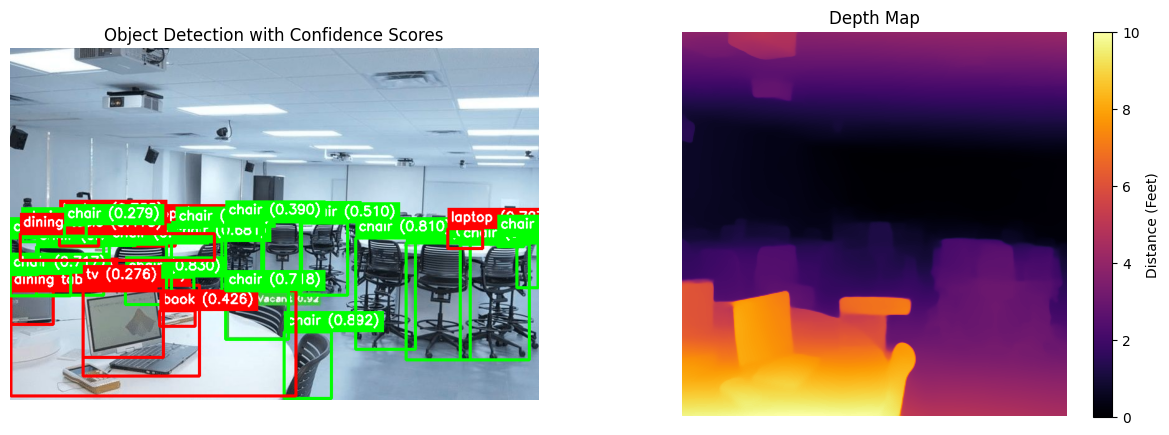

In [ ]:
class SceneAnalyzer:
    def __init__(self, depth_model_name="Intel/dpt-large", yolo_model_name="yolov8x.pt"):
        """Initialize models and parameters"""
        self.depth_feature_extractor = DPTFeatureExtractor.from_pretrained(depth_model_name)
        self.depth_model = DPTForDepthEstimation.from_pretrained(depth_model_name)
        self.yolo_model = YOLO(yolo_model_name)
        self.scaling_factor = 10
        self.safety_threshold = 6  # minimum safe distance in feet
        self.historical_data = []

    def detect_objects(self, image_path):
        """
        Perform object detection on the image

        Args:
            image_path (str): Path to the image file

        Returns:
            list: List of YOLO detection results
        """
        results = self.yolo_model(image_path)
        return results

    def estimate_depth(self, image):
        """Estimate depth map from image and return both depth map and scale factors"""
        depth_inputs = self.depth_feature_extractor(images=image, return_tensors="pt")
        with torch.no_grad():
            depth_outputs = self.depth_model(**depth_inputs)
            predicted_depth = depth_outputs.predicted_depth.squeeze().cpu().numpy()

        depth_min, depth_max = predicted_depth.min(), predicted_depth.max()
        normalized_depth = (predicted_depth - depth_min) / (depth_max - depth_min)

        # Calculate scale factors between original image and depth map
        original_height, original_width = np.array(image).shape[:2]
        depth_height, depth_width = normalized_depth.shape
        height_scale = depth_height / original_height
        width_scale = depth_width / original_width

        return normalized_depth * self.scaling_factor, (height_scale, width_scale)

    def draw_annotations(self, image, detections, names, confidences):
        """Draw bounding boxes and labels using cv2 with enhanced visibility"""
        annotated_image = image.copy()

        for i, (box, class_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
            x1, y1, x2, y2 = map(int, box)

            # Use different colors for different classes
            color = (0, 255, 0) if names[class_id] == 'chair' else (0, 0, 255)

            # Draw rectangle with thicker lines
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 3)

            # Create more detailed label
            label = f"{names[class_id]} ({conf:.3f})"

            # Make text background and font larger
            font_scale = 0.7
            thickness = 2
            (label_width, label_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
            )

            # Draw label background
            cv2.rectangle(
                annotated_image,
                (x1, y1 - label_height - baseline - 10),
                (x1 + label_width + 10, y1),
                color,
                -1,
            )

            # Draw label text in white for better contrast
            cv2.putText(
                annotated_image,
                label,
                (x1 + 5, y1 - baseline - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                thickness,
            )

            # Print detection details to console
            print(f"Detected {names[class_id]} with {conf:.3f} confidence at position {x1},{y1},{x2},{y2}")

        return annotated_image

    def analyze_scene(self, image_path):
        """Main method to analyze the scene with enhanced debugging"""
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]

        print("\nDetection Results:")
        print("-" * 50)

        # Print all detections with confidence scores
        for i, (box, cls, conf) in enumerate(zip(yolo_results.boxes.xyxy,
                                               yolo_results.boxes.cls,
                                               yolo_results.boxes.conf)):
            print(f"Object {i+1}:")
            print(f"  Class: {yolo_results.names[int(cls)]}")
            print(f"  Confidence: {conf:.3f}")
            print(f"  Bounding Box: {box.tolist()}")
            print()

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

    def calculate_spatial_relationships(self, detections, names):
        """Calculate spatial relationships between objects"""
        relationships = []
        if len(detections.xyxy) > 1:
            # Calculate center points of all bounding boxes
            centers = np.array([
                [(box[0] + box[2])/2, (box[1] + box[3])/2]
                for box in detections.xyxy
            ])

            tree = KDTree(centers)
            for i, pos in enumerate(centers):
                distances, indices = tree.query(pos.reshape(1, -1), k=2)
                if len(indices[0]) > 1:
                    nearest_neighbor = indices[0][1]
                    # Use object names instead of class IDs
                    relationships.append({
                        'object1': names[detections.class_id[i]],
                        'object2': names[detections.class_id[nearest_neighbor]],
                        'distance': float(distances[0][1]),
                        'relative_position': 'left' if centers[i][0] < centers[nearest_neighbor][0] else 'right'
                    })
        return relationships

    def generate_safety_alerts(self, detections, names):
        """Generate safety alerts based on object proximity"""
        alerts = []
        processed_pairs = set()  # To avoid duplicate alerts

        for i in range(len(detections.xyxy)):
            for j in range(i + 1, len(detections.xyxy)):
                # Create a unique pair identifier
                pair_id = tuple(sorted([i, j]))
                if pair_id in processed_pairs:
                    continue

                processed_pairs.add(pair_id)

                box1 = detections.xyxy[i]
                box2 = detections.xyxy[j]
                center1 = [(box1[0] + box1[2])/2, (box1[1] + box1[3])/2]
                center2 = [(box2[0] + box2[2])/2, (box2[1] + box2[3])/2]
                dist = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

                if dist < self.safety_threshold * 100:  # Convert feet to pixels
                    alerts.append({
                        'severity': 'HIGH' if dist < self.safety_threshold * 50 else 'MEDIUM',
                        'message': f"Safety concern: {names[detections.class_id[i]]} and {names[detections.class_id[j]]} are too close",
                        'distance': dist / 100  # Convert to feet
                    })
        return alerts

    def analyze_scene(self, image_path):
        """Main method to analyze the scene"""
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        estimated_distance, scale_factors = self.estimate_depth(image)
        yolo_results = self.detect_objects(image_path)[0]  # Get first result

        # Convert YOLO results to supervision detections
        detections = sv.Detections(
            xyxy=yolo_results.boxes.xyxy.cpu().numpy(),
            confidence=yolo_results.boxes.conf.cpu().numpy(),
            class_id=yolo_results.boxes.cls.cpu().numpy().astype(int)
        )

        # Draw annotations using our custom method
        annotated_image = self.draw_annotations(
            image_np,
            detections,
            yolo_results.names,
            detections.confidence
        )

        # Process detection results
        object_data = []
        height_scale, width_scale = scale_factors

        for i, (xyxy, confidence, class_id) in enumerate(zip(detections.xyxy, detections.confidence, detections.class_id)):
            x1, y1, x2, y2 = map(int, xyxy)

            # Scale coordinates for depth map
            scaled_x1 = int(x1 * width_scale)
            scaled_y1 = int(y1 * height_scale)
            scaled_x2 = int(x2 * width_scale)
            scaled_y2 = int(y2 * height_scale)

            # Ensure coordinates are within bounds
            scaled_x1 = min(max(0, scaled_x1), estimated_distance.shape[1] - 1)
            scaled_y1 = min(max(0, scaled_y1), estimated_distance.shape[0] - 1)
            scaled_x2 = min(max(0, scaled_x2), estimated_distance.shape[1] - 1)
            scaled_y2 = min(max(0, scaled_y2), estimated_distance.shape[0] - 1)

            # Calculate object distance using scaled coordinates
            object_depth = estimated_distance[scaled_y1:scaled_y2, scaled_x1:scaled_x2]
            object_distance = float(np.mean(object_depth)) if object_depth.size > 0 else None

            # Store object data
            object_data.append({
                'type': yolo_results.names[class_id],
                'confidence': float(confidence),
                'distance': object_distance,
                'position': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}
            })

        # Calculate additional analysis using object names instead of class IDs
        spatial_relationships = self.calculate_spatial_relationships(detections, yolo_results.names)
        safety_alerts = self.generate_safety_alerts(detections, yolo_results.names)

        # Store historical data (without JSON serialization)
        analysis_data = {
            'timestamp': datetime.now().isoformat(),
            'objects': object_data,
            'relationships': spatial_relationships,
            'alerts': safety_alerts
        }
        self.historical_data.append(analysis_data)

        # Create basic visualizations
        fig = plt.figure(figsize=(15, 5))

        # Original image with annotations
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Object Detection with Confidence Scores")
        plt.axis("off")

        # Depth map
        plt.subplot(1, 2, 2)
        depth_plot = plt.imshow(estimated_distance, cmap="inferno")
        plt.colorbar(depth_plot, label="Distance (Feet)")
        plt.title("Depth Map")
        plt.axis("off")

        return {
            'annotated_image': annotated_image,
            'depth_map': estimated_distance,
            'object_data': object_data,
            'spatial_relationships': spatial_relationships,
            'safety_alerts': safety_alerts,
            'figure': fig
        }

# Example usage
if __name__ == "__main__":
    analyzer = SceneAnalyzer()

    image_paths = [
        "blackchairs.jpeg"
    ]

    for image_path in image_paths:
        print(f"\nAnalyzing {image_path}...")
        results = analyzer.analyze_scene(image_path)

        # Enhanced printing of object details
        print("\nDetected Objects Summary:")
        print("-" * 50)
        for obj in results['object_data']:
            print(f"Type: {obj['type']}")
            print(f"Confidence: {obj['confidence']:.3f}")
            print(f"Estimated Distance: {obj['distance']:.2f} feet")
            print("-" * 30)

        if results['safety_alerts']:
            print("\nSafety Alerts:")
            for alert in results['safety_alerts']:
                print(f"- {alert['severity']}: {alert['message']} ({alert['distance']:.2f} feet)")

        if results['spatial_relationships']:
            print("\nSpatial Relationships:")
            for rel in results['spatial_relationships']:
                print(f"- {rel['object1']} is {rel['relative_position']} of {rel['object2']}")

        plt.figure(results['figure'].number)
        plt.show()